# Boltzmann emulator example

This notebook demonstrates how to initialize, train, and predict using a Boltzmann code emulator. If you look at the other notebook in this directory (`making_training_power_spectra`), you can see how the training data (i.e. the power spectra) are created using CLASS. Of course, this emulator doesn't care where the power spectra came from. It's on the user(s) to make sure there is enough training data to make a use-able emulator.

In this notebook you will see:
1. Plots of what the training data should look like.
2. The emulator initialized and trained.
3. A predicted power spectrum, compared to what it's "true" value is from CLASS.

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import boltzmann_emulator as BE
%matplotlib inline

In [2]:
plt.rc("text", usetex=True)
plt.rc("font", size=18, family="serif")

In [3]:
#Load in the data needed for the emulator, computed in the other notebook
emulator_components = pickle.load( open( "emulator_components.p", "rb" ) )
print(emulator_components.keys())

['Pks', 'k', 'parameters', 'zs']


In [4]:
zs = emulator_components['zs']
k = emulator_components['k']
parameters = emulator_components['parameters']
Pks = emulator_components['Pks']
print("Number of redshifts: ", len(zs))
print("Number of wavenumbers: ", len(k))
print("Shape of cosmological parameters: ", parameters.shape)
print("Shape of P(k,z): ", Pks.shape)

('Number of redshifts: ', 10)
('Number of wavenumbers: ', 200)
('Shape of cosmological parameters: ', (100, 2))
('Shape of P(k,z): ', (100, 2000))


Scatter plot of all cosmologies here


Text(0,0.5,'$\\sigma_8$')

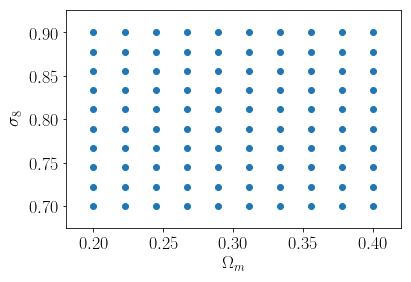

In [5]:
print("Scatter plot of all cosmologies here")
plt.scatter(parameters[:, 1], parameters[:, 0])
plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"$\sigma_8$")

Power spectra at z=0 for three cosmologies


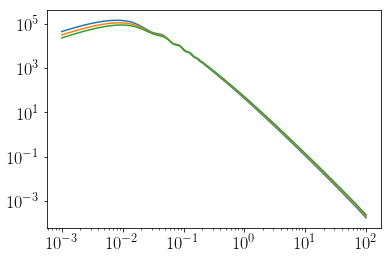

In [6]:
print("Power spectra at z=0 for three cosmologies")
for i in range(3):
    plt.loglog(k, Pks[i, :len(k)])

Power spectra for one cosmology
It is P(k,z) at 10 redshifts stacked end to end
Note that in this plot, the x axis is meaningless


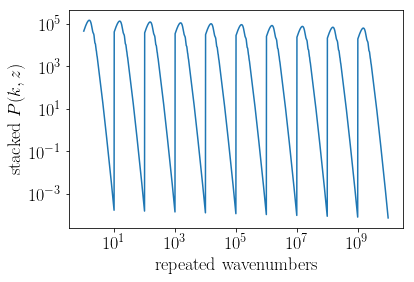

In [7]:
print("Power spectra for one cosmology")
print("It is P(k,z) at 10 redshifts stacked end to end")
print("Note that in this plot, the x axis is meaningless")
x = np.logspace(0, 10, len(Pks[0]))
plt.loglog(x, Pks[0])
plt.xlabel(r"repeated wavenumbers")
plt.ylabel(r"stacked $P(k,z)$")
plt.savefig("example_pkz.png", dpi=300, bbox_inches="tight")

In [8]:
#Step 2 - create the emulator
Emu = BE.boltzmulator(parameters, zs, k, Pks)
Emu.train()

In [9]:
#Step 3 - pick a point in parameter space and try to predict on it
test_params = parameters[0]
Pk_predicted = Emu.predict(test_params)
print(Pk_predicted.shape)

(2000,)


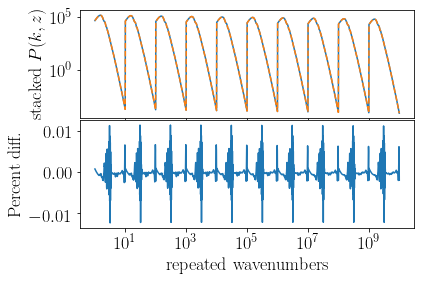

In [10]:
#Plot the true vs predicted P(k,z)
fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True)
ax[0].loglog(x, Pks[0])
ax[0].loglog(x, Pk_predicted, ls='--')
ax[1].plot(x, 100*(Pks[0] - Pk_predicted)/Pks[0])
ax[1].set_ylabel(r"Percent diff.")
ax[1].set_xlabel(r"repeated wavenumbers")
ax[0].set_ylabel(r"stacked $P(k,z)$")
plt.subplots_adjust(hspace=0.02)
#fig.savefig("prediction_example.png", dpi=300, bbox_inches="tight")

## Comparing to the truth

Ok, this looks good so far, but we would like to be able to visualize this all a bit better. Let's rebuild the emulator leaving out a random training point (point 55), and try to predict that point.

Scatter plot of all cosmologies here


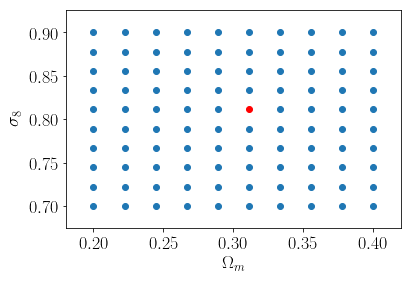

In [11]:
test_index = 55
new_parameters = np.delete(parameters, test_index, 0)
new_Pks = np.delete(Pks, test_index, 0)
test_params = parameters[test_index]
test_Pks = Pks[test_index]

print("Scatter plot of all cosmologies here")
plt.scatter(new_parameters[:, 1], new_parameters[:, 0])
plt.scatter(test_params[1], test_params[0], c='r')
plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"$\sigma_8$")
plt.savefig("leave_one_out_test.png", dpi=300, bbox_inches="tight")

In [12]:
Emu = BE.boltzmulator(new_parameters, zs, k, new_Pks)
Emu.train()
Pk_predicted = Emu.predict(test_params)

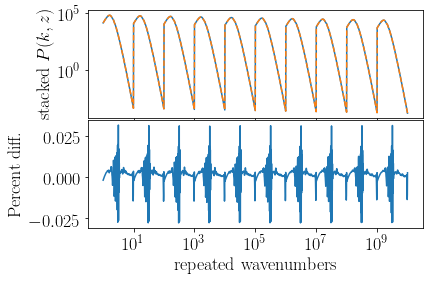

In [13]:
#Plot the true vs predicted P(k,z)
fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True)
ax[0].loglog(x, Pks[test_index])
ax[0].loglog(x, Pk_predicted, ls="--")
ax[1].plot(x, 100*(Pks[test_index] - Pk_predicted)/Pks[test_index])
ax[1].set_ylabel(r"Percent diff.")
ax[1].set_xlabel(r"repeated wavenumbers")
ax[0].set_ylabel(r"stacked $P(k,z)$")
plt.subplots_adjust(hspace=0.02)
fig.savefig("prediction_example.png", dpi=300, bbox_inches="tight")

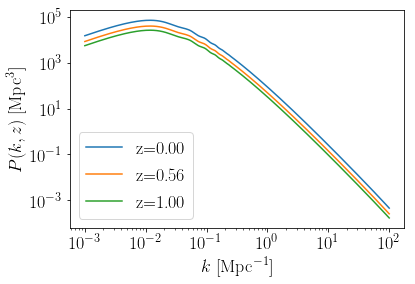

In [14]:
#Let's plot the predicted power spectrum for a few redshifts
for i in [0, 5, 9]:
    lo = i*len(k)
    hi = (i+1)*len(k)
    plt.loglog(k, Pk_predicted[lo:hi], label="z=%.2f"%zs[i])
plt.legend()
plt.xlabel(r"$k\ [{\rm Mpc}^{-1}]$")
plt.ylabel(r"$P(k,z)\ [{\rm Mpc^3}]$")
plt.savefig("pk_at_3redshifts.png", dpi=300, bbox_inches="tight")

## Looks ok to me

The predicted emulator is accurate at the sub-percent level at large scales, with only 200 wavenumbers per power spectra. It's really only around $k\sim 1$ or so that the accuracy becomes worse than ~1%. This could be improved with more wavenumbers and more training cosmologies, both of which are free to compute for us.